## Setup

### Hookean Triplet

In [5]:
from __future__ import annotations
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from jax.tree_util import register_dataclass
import jaxtyping
import optax
import matplotlib.pyplot as plt
import numpy as np

import hodel


@register_dataclass
@dataclass
class TripletAux:
    """Parametrized external force."""

    f: jax.Array
    c: jax.Array


@register_dataclass
@dataclass
class Triplet:
    """3 node spring with [K_1, K_2]"""

    l_k: jax.Array

    @classmethod
    def init(cls, xf0: jax.Array, xb0: jax.Array) -> Triplet:
        x0 = xb0[0]
        x1, x2 = xf0
        return cls(jnp.array([x1 - x0, x2 - x1]))

    @staticmethod
    def get_strain(x0, x1, x2, l_k) -> jax.Array:
        return jnp.array([x1 - x0, x2 - x1]) / l_k

    def get_K(self, del_strain: jax.Array, Theta: jaxtyping.PyTree) -> jax.Array:
        return jnp.diag(jnp.abs(Theta))

    def get_energy(
        self,
        xf: jax.Array,
        xb: jax.Array,
        Theta: jax.Array,
        aux: TripletAux,
        carry: None,
    ) -> jax.Array:
        # xb = [x0], xf = [x1, x2]
        x0 = xb[0]
        x1, x2 = xf
        del_strain = self.get_strain(x0, x1, x2, self.l_k) - 1.0
        return self.core_energy_fn(del_strain, Theta)

    def core_energy_fn(self, del_strain, Theta):
        return 0.5 * del_strain @ self.get_K(del_strain, Theta) @ del_strain


def get_W(lambda_: jax.Array, aux: TripletAux):
    return lambda_ * aux.f + aux.c


def fixed_0(lambda_: jax.Array, aux: TripletAux) -> jax.Array:
    return jnp.array([0.0])


### Non-linear Triplet

In [6]:
import flax.linen as nn


class SymKNet(nn.Module):
    """Symmetric 2 x 2 K"""

    hidden_size: int
    offset: float

    @nn.compact
    def __call__(self, del_strain):
        x = nn.softplus(nn.Dense(self.hidden_size)(del_strain))
        x = nn.softplus(nn.Dense(self.hidden_size)(x))
        return jnp.exp(nn.Dense(1)(x)[0] + self.offset)


model = SymKNet(10, -6.5)


@register_dataclass
@dataclass
class NNTriplet(Triplet):
    """3 node spring where Theta is parameters for a neural network."""

    def get_K(self, del_strain: jax.Array, Theta: nn.FrozenDict) -> jax.Array:
        a = model.apply(Theta, del_strain[0:1])
        b = model.apply(Theta, del_strain[1:2])
        return jnp.array([[a, 0.0], [0.0, b]])  # type: ignore

## Learning

In [7]:
import csv

# Initialize lambdas, xfs from csv (Abaqus)
with open("1d_train.csv") as f:
    reader = csv.reader(f)
    lambda_list = []
    xf_list = []
    for row in reader:
        lambda_list.append(float(row[0]))
        xf_list.append([float(i) for i in row[2:]])
    lambdas = jnp.asarray(lambda_list)
    xf_stars = jnp.asarray(xf_list)
    xf0 = xf_stars[0]

with open("1d_strain.csv") as f:
    reader = csv.reader(f)
    strain_list = []
    stress_list = []
    for row in reader:
        strain_list.append(float(row[0]))
        stress_list.append(float(row[1]))
    strain_stars = jnp.asarray(strain_list)
    stress_stars = jnp.asarray(stress_list)

# Abaqus applied force
aux = TripletAux(jnp.array([0.0, 1.5]), jnp.array([0.0, 0.0]))
key = jax.random.PRNGKey(10)
params = model.init(key, jnp.zeros(1))
nn_energy = NNTriplet.init(xf0, jnp.array([0.0]))
nn_sim = hodel.HODEL(nn_energy.get_energy, get_W, fixed_0)
#nn_sim.solve(lambdas, xf0, params, aux, config=hodel.SolverConfig(nsteps=10))

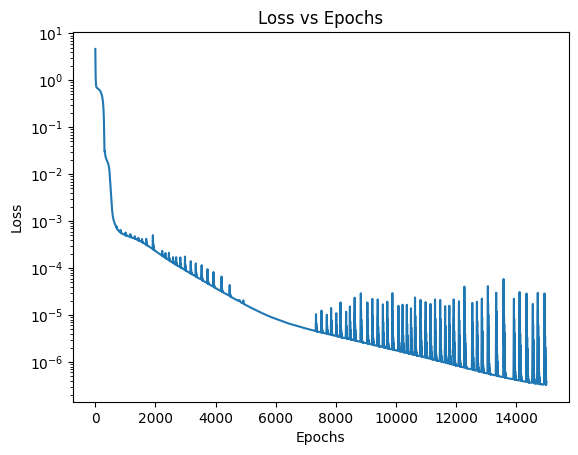

In [8]:
lr = 1e-3
nepochs = 15000
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=nepochs // 2, alpha=1e-1)

final_params, L = nn_sim.learn(
    lambdas,
    xf0,
    xf_stars,
    params,
    aux,
    method=hodel.Method.Minimization,
    config=hodel.SolverConfig(nsteps=5),
    optim=optax.adam(schedule),
    nepochs=nepochs,
)
final_xfs = nn_sim.solve(lambdas, xf0, final_params, aux)
plt.plot(L)
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Visualization

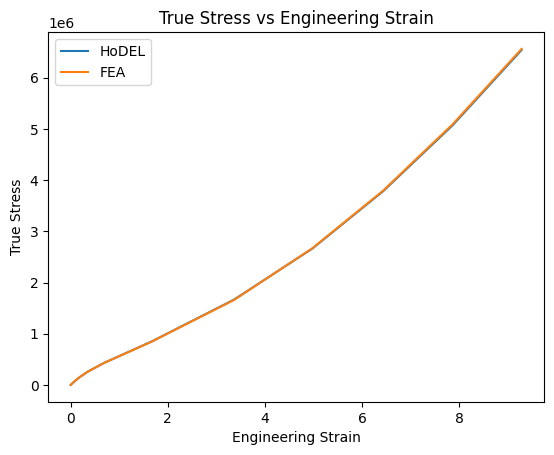

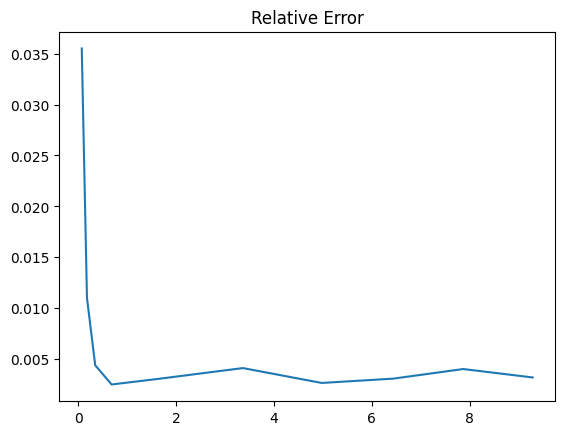

In [9]:
xbs = jax.vmap(lambda lambda_: fixed_0(lambda_, aux))(lambdas)
del_strains = (
    jax.vmap(lambda xf, xb: nn_energy.get_strain(xb[0], xf[0], xf[1], nn_energy.l_k))(
        xf_stars, xbs
    )
    - 1
)
strain = del_strains[:, 0]
dEdstrain = jnp.sum(
    jax.vmap(
        lambda strain_: jax.grad(nn_energy.core_energy_fn, 0)(strain_, final_params)
    )(del_strains),
    axis=1,
)

"""plt.plot(strain, dEdstrain)
plt.ylabel("dE/dStrain")
plt.xlabel("Engineering Strain")
plt.title("dE/dStrain vs Engineering Strain")
plt.show()"""

r = 1e-3
L = 0.075
A = jnp.pi * r ** 2
eng_stress = dEdstrain / (A * L)
true_stress = eng_stress * (1 + strain)
plt.plot(strain, true_stress, label="HoDEL")
plt.plot(strain_stars, stress_stars, label="FEA")
plt.ylabel("True Stress")
plt.xlabel("Engineering Strain")
plt.title("True Stress vs Engineering Strain")
plt.legend()
plt.show()

plt.plot(strain_stars, jnp.abs(stress_stars - true_stress)/true_stress)
plt.title("Relative Error")
plt.show()

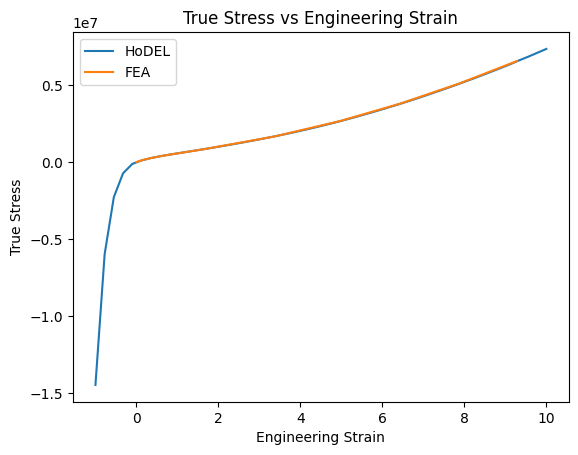

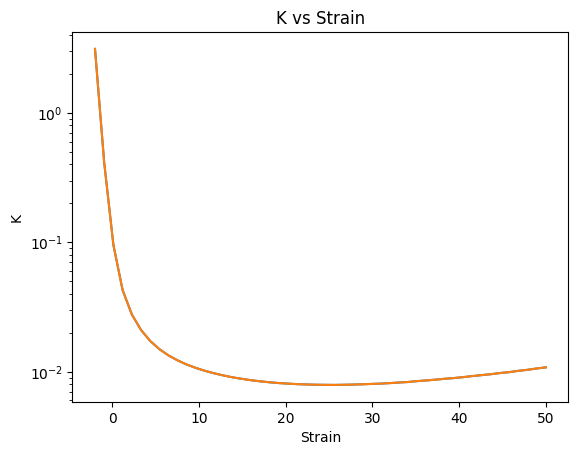

In [10]:
xbs = jax.vmap(lambda lambda_: fixed_0(lambda_, aux))(lambdas)
del_strains = jnp.linspace(-1, 10).repeat(2).reshape(-1, 2)
strain = del_strains[:, 0]
dEdstrain = jnp.sum(
    jax.vmap(
        lambda strain_: jax.grad(nn_energy.core_energy_fn, 0)(strain_, final_params)
    )(del_strains),
    axis=1,
)

r = 1e-3
L = 0.075
A = jnp.pi * r ** 2
eng_stress = dEdstrain / (A * L)
true_stress = eng_stress * (1 + jnp.abs(strain))
plt.plot(strain, true_stress, label="HoDEL")
plt.plot(strain_stars, stress_stars, label="FEA")
#plt.plot(strain, analytical_stress)
plt.ylabel("True Stress")
plt.xlabel("Engineering Strain")
plt.title("True Stress vs Engineering Strain")
plt.legend()
plt.show()

strains = jnp.linspace(-2, 50).repeat(2).reshape(-1, 2)
K = jax.vmap(lambda strain_: nn_energy.get_K(strain_, final_params))(strains)[:,0,0]
plt.plot(strains, K)
plt.ylabel("K")
plt.xlabel("Strain")
plt.yscale("log")
plt.title("K vs Strain")
plt.show()